# 11-year NANOGrav Stochastic Background Analysis

**Note:** Any changes made in a docker container will be lost when that container is removed, and will not appear if a new container is started.  To make persistent changes to this file copy it to the `local_data/` directory and work from there.

## Overview
In this notebook we will give several examples of how to reproduce the results from the 11-year NANOGrav stochastic background analysis paper.

All models are pre-defined in `models/` with names corresponding to those in Table 1 of the paper. All models and priors are exactly as described in the text and Table 2 of the paper.

We will make use of the [`PTMCMCSampler`](https://github.com/jellis18/PTMCMCSampler) package; however, the model functions return a `PTA` that has `get_lnlikelihood` and `get_lnprior` methods that can be used in any sampler that reads in a likelihood and prior function.

In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import numpy as np
import matplotlib.pyplot as plt

from utils import get_pulsars, setup_sampler, PostProcessing
from models import models

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

No PINT? Meh...


## Initialize pulsars

In this step we use the convienience function `get_pulsars` to read in the 34 pulsars used in the NANOGrav analysis. This can take several minutes as the data sets are quite large.

This returns a list of `enterprise` `Pulsar` objects that will be used in setting up our PTA in the next step.

By default this will use the 34 pulsars from the NANOGrav analysis and DE436 ephemeris but you can pass keyword arguments `psrlist` (a list of pulsar names to use in the analysis) and `ephem` (a string such as 'DE436') for the ephemeris version.

In [ ]:
psrs = get_pulsars()

## Setup the model

In this step we set up the model. All of these models follow the naming convention in Table 2 of the paper.

All models (other than `model_1`, which is for single pulsar noise analyses) have the following arguments:

* **psrs**: A list of pulsar objects that we created in the step above
* **psd**: The PSD to use for the common signals. The three choices are `powerlaw`, `turnover`, or `spectrum` following the description of section 3.2 in the text. `powerlaw` is the default choice
* **gamma_common**: The fixed spectral index value (i.e. 13/3 for SMBHB backgrounds). By default this is set to `None` and the spectral index will vary as a free parameter.
* **upper_limit**: Specifies whether or not we are performing an upper limit. If so, we will use *uniform* priors on the red noise and common red noise amplitudes, otherwise we use *log-uniform* priors
* **bayesephem**: Specifies whether or not to use the dynamical ephemeris model described in the text.

Below we run Model 2A which contains a common red noise signal modeled as a powerlaw with fixed spectral index 13/3. We will include Bayesian ephemeris modeling and compute the upper limit on the common red process.

In [ ]:
pta = models.model_2a(psrs, psd='powerlaw', bayesephem=True, upper_limit=True, gamma_common=4.33)
print(pta.params)

## Setup the sampler

We initialize the sampler the likelihood and prior function
from the PTA object. We set up an initial jump covariance matrix
with fairly small jumps as this will be adapted as the MCMC runs.

We will setup an output directory in `outdir` that will contain
the chain (first n columns are the samples for the n parameters 
and last 4 are log-posterior, log-likelihood, acceptance rate, and
an indicator variable for parallel tempering but it doesn't matter
because we aren't using parallel tempering).

We also output text files with the parameter labels and parameter priors
in the same order as the chain output. 

We then add several custom jump proposals to the mix based on
whether or not certain parameters are in the model. These are
all either draws from the prior distribution of parameters or
draws from uniform distributions.

In [ ]:
outdir = 'local_data/chains'
sampler = setup_sampler(pta, resume=False, outdir=outdir)

Adding ephemeris model prior draws...

Adding GWB uniform distribution draws...



## Sample!

Now we run the sampler. First we set the number of iterations. For production runs we usually do around 5 million samples. Next we set the initial parameter vector (as that is the form in which the sampler expects the input) by drawing from the prior or our parameters.

In running the sampler itself we are setting various weights for different jumps. This is just a relative weighting of how often we will call these types of jumps. 

In [ ]:
N = 10**6 # one mega-sample!
x0 = np.hstack(p.sample() for p in pta.params)
sampler.sample(x0, N, AMweight=25, SCAMweight=40, DEweight=55)

Finished 1.00 percent in 877.359552 s Acceptance rate = 0.422244Adding DE jump with weight 55
Finished 47.80 percent in 31893.894316 s Acceptance rate = 0.456916

## Analyze output

We read in the chain output and pass it to the PostProcessing class that has some useful plotting methods. Lastly we compute the upper limit on the common red noise process.

In [2]:
chain = np.loadtxt(outdir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outdir + '/pars.txt', dtype='S42')

pp = PostProcessing(chain, pars)

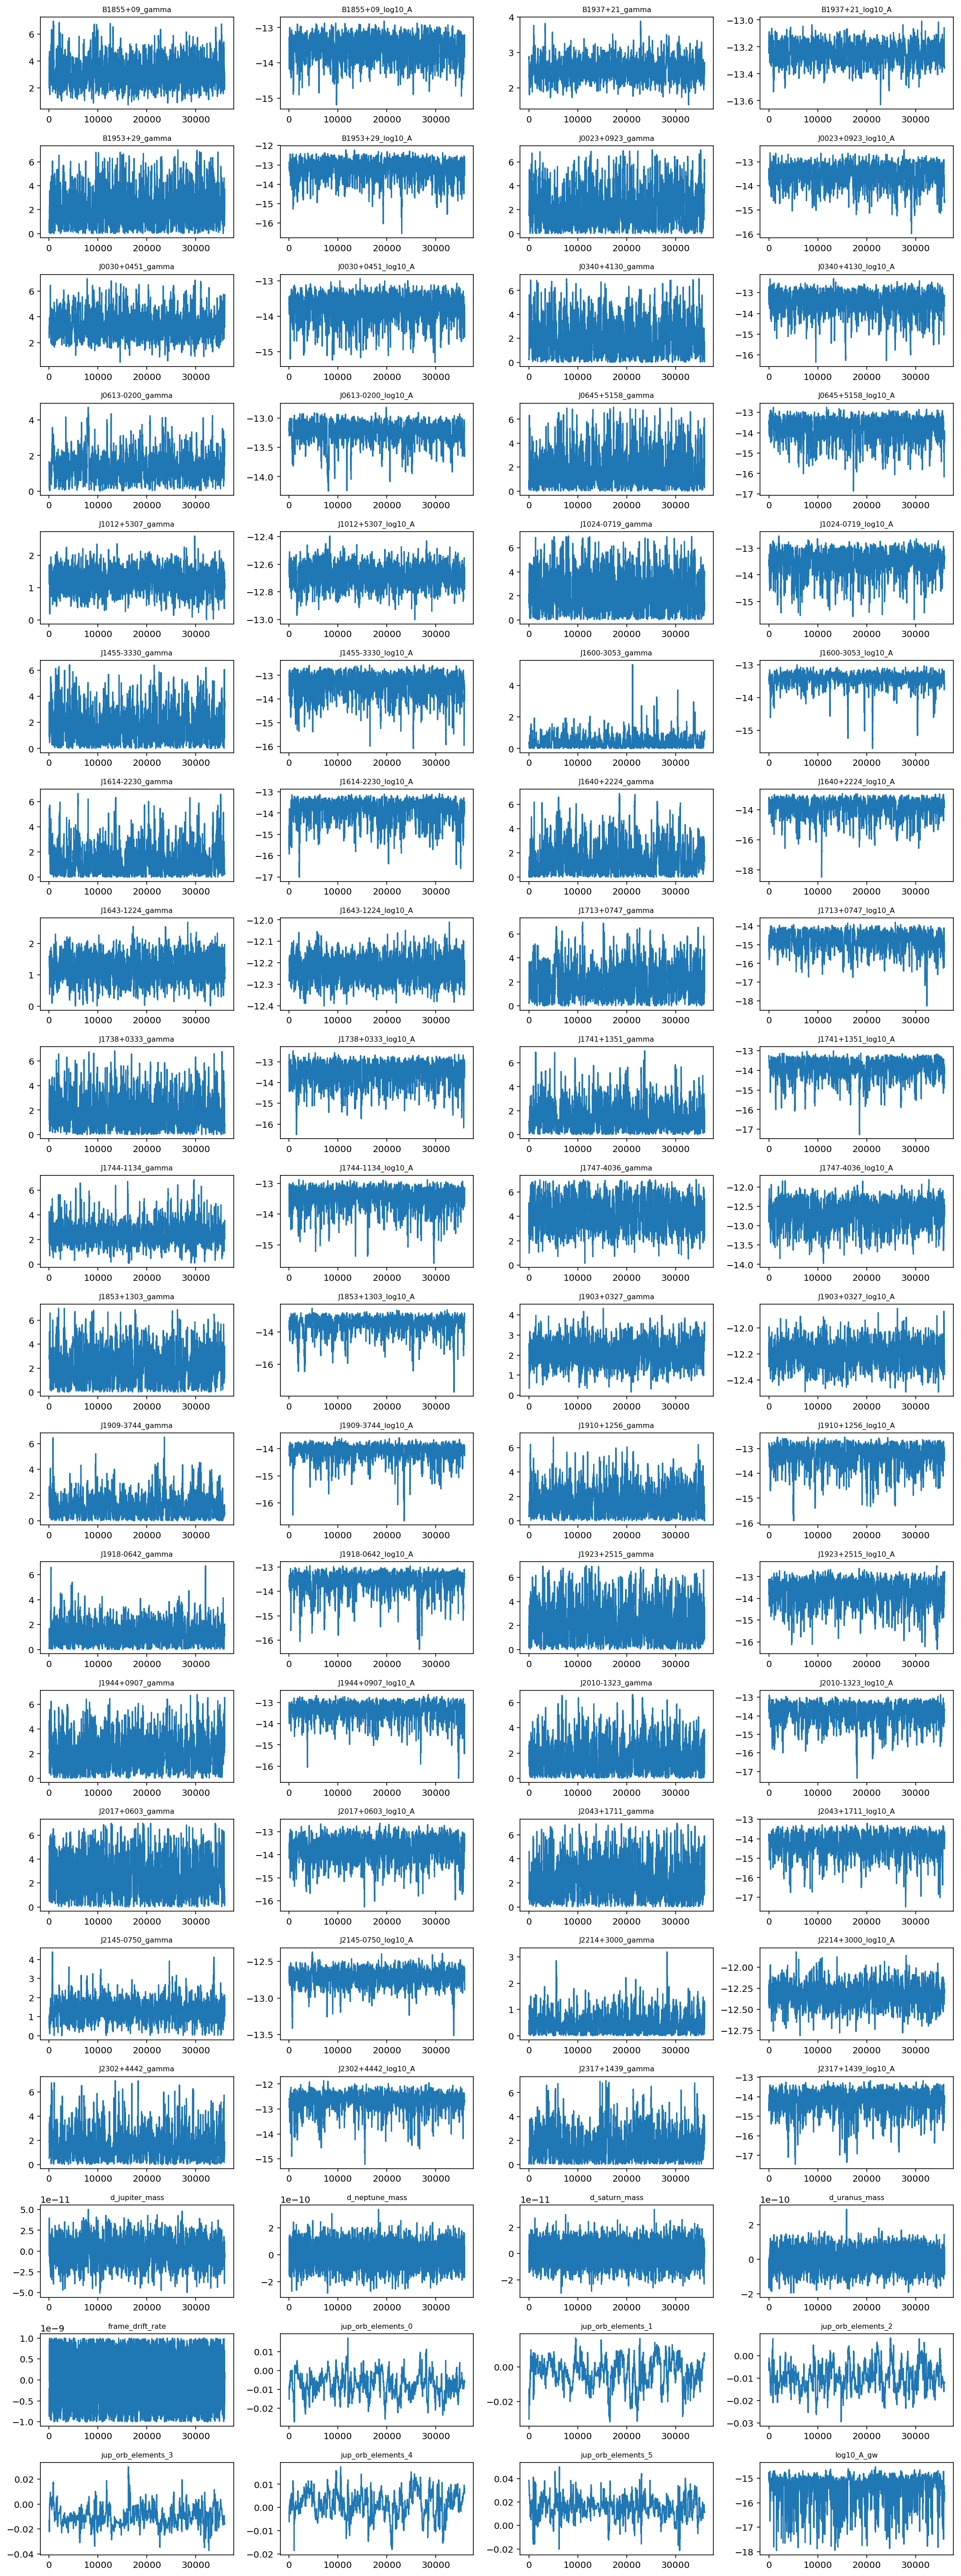

In [3]:
pp.plot_trace()

**Note:** This example was only run with a fraction of the samples used in the analysis paper, yet we are within the quoted uncertainty on the upper limit listed in Table 4.

1.35183436223e-15


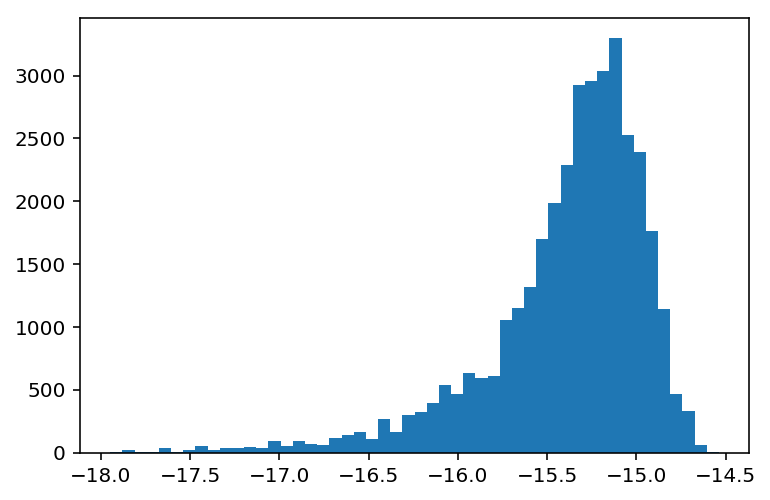

In [4]:
indAgwb = pars.index('log10_A_gw')
plt.hist(chain[burn:, indAgwb], 50);
print(10**np.percentile(chain[burn:, indAgwb], q=95))